# Gaussian Model For Anomaly Detection

In this notebook we will apply a Gaussian Model to detect outliers. The main assumption is that the data follow a Gausssian Distribution. 

- First we will build a model that will learn the underlaying structure of the dataset.
- Then we will identify the data points that have a very low probability of being normal, those points will be marked as outliers


In [18]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
% matplotlib inline

In [98]:
def estimateGaussian(dataset):
    '''
    Estimate the Gaussian Distribution of the dataset by calculating mean and variance of features 
    Args: 
    -----
            dataset(pandas.Dataframe): input data
            
    Returns:
    -------
            mu(ndarray): mean of each feature 
            sigma(ndarray): standard deviation of each feature
    '''
    mu = np.mean(dataset.values, axis = 0)
    sigma = np.std(dataset.values, axis = 0)
    return mu,sigma

def multivariateGaussian(dataset, mu , sigma):
    '''
    Estimate the Probability Density Function(pdf) for a multivariate Gaussian
    Args:
    -----
            dataset(pandas.DataFrame): input dataset
            mu(ndarray): mean of each feature 
            sigma(ndarray): standard deviation of each feature
            
    Returns:
    --------
            probs(ndarray): probabilities estimated by the pdf
            
    '''
    probs = multivariate_normal.pdf(x = dataset, mean = mu, cov = sigma)
    return probs

def selectThreshold(probs, test):
    '''
    Find the best thresholdcomparing the f1 score obrained
    Args:
    -----
            probs(ndarray): probabilities estimated by the pdf
            test(pandas.Series): test data
    
    Returns:
    --------
            best_f1(float): best f1 score found
            best_epsilon(float): best threshold found
    '''
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in epsilons:
        predictions = (probs < epsilon) # Create an array of predictions (boolean)
        f = f1_score(test, predictions, average = "binary") 
        # Find the best F1 score and epsilon
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

## Data

In [143]:
train_df = pd.read_csv('../data/tr_server_data.csv', header= None, names = ['Latency(ms)', 'Throughput(mb/s)'])
train_df.head()

,Latency(ms),Throughput(mb/s)
0,13.047,14.741
1,13.409,13.763
2,14.196,15.853
3,14.915,16.174
4,13.577,14.043


In [92]:
cv_df = pd.read_csv('../data/cv_server_data.csv', header = None, names = ['Latency(ms)', 'Throughput(mb/s)'])
cv_df.head()

,Latency(ms),Throughput(mb/s)
0,15.790,14.921
1,13.640,15.330
2,14.866,16.474
3,13.585,13.989
4,13.464,15.635


In [90]:
test_df = pd.read_csv('../data/gt_server_data.csv', header = None)
test_df.head()

,0
0,0
1,0
2,0
3,0
4,0


# Exploratory Data Analysis

The data have only 2 dimenions, so we can try to visualize them on a 2-dimensional plot, to understand better how they are distributed

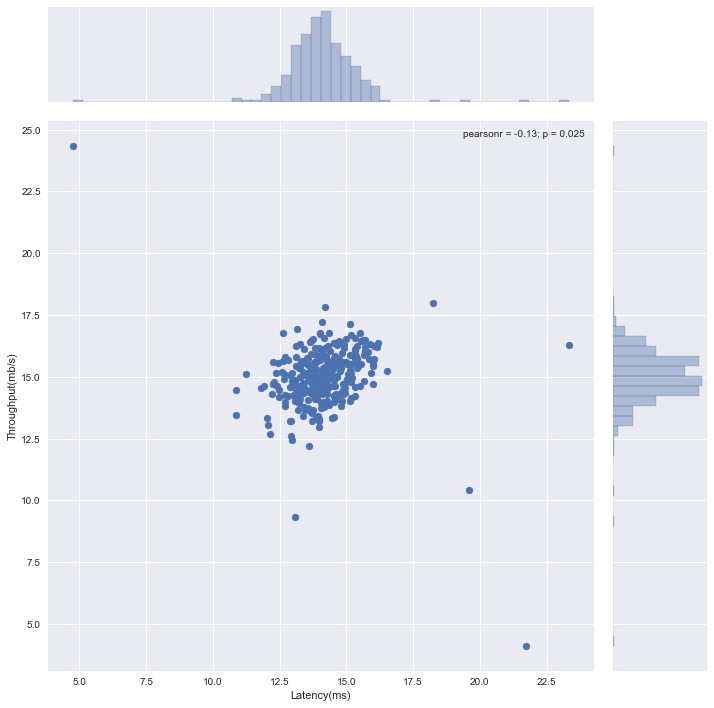

In [164]:
plt.rcParams["patch.force_edgecolor"] = True
sns.jointplot('Latency(ms)', 'Throughput(mb/s)', size = 10, data = train_df, kind='scatter')

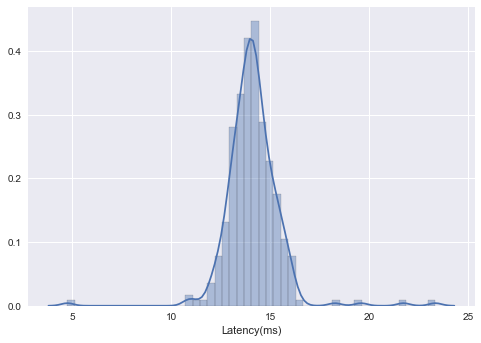

In [165]:
sns.distplot(train_df['Latency(ms)'])

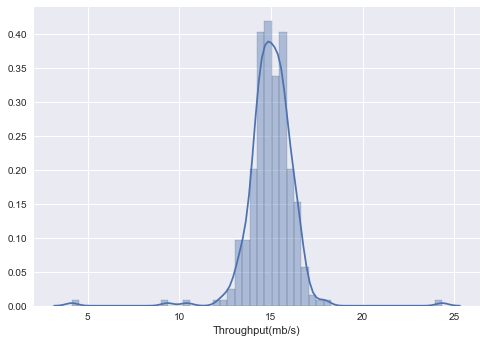

In [166]:
sns.distplot(train_df['Throughput(mb/s)'])

From these plots we can notice that the data follow a normal distribution. For this reason the assumption we did at the beginning was correct. We can now identify the points that don't follow the distribution and mark them as outliers

## Gaussian Model

In [132]:
mu, sigma = estimateGaussian(train_df)

In [133]:
# Calculate the probabilities
probs = multivariateGaussian(train_df, mu, sigma)
probs_cv = multivariateGaussian(cv_df, mu, sigma)
# Calculate f1 and threshold
f1score, threshold = selectThreshold(probs_cv,test_df)

Now that we have found the best threshold we are ready to find the outliers in our dataset

In [144]:
outliers = np.where(probs < threshold)
train_df['outlier'] = np.zeros(len(train_df))

In [145]:
train_df.iloc[outliers,2] = 1

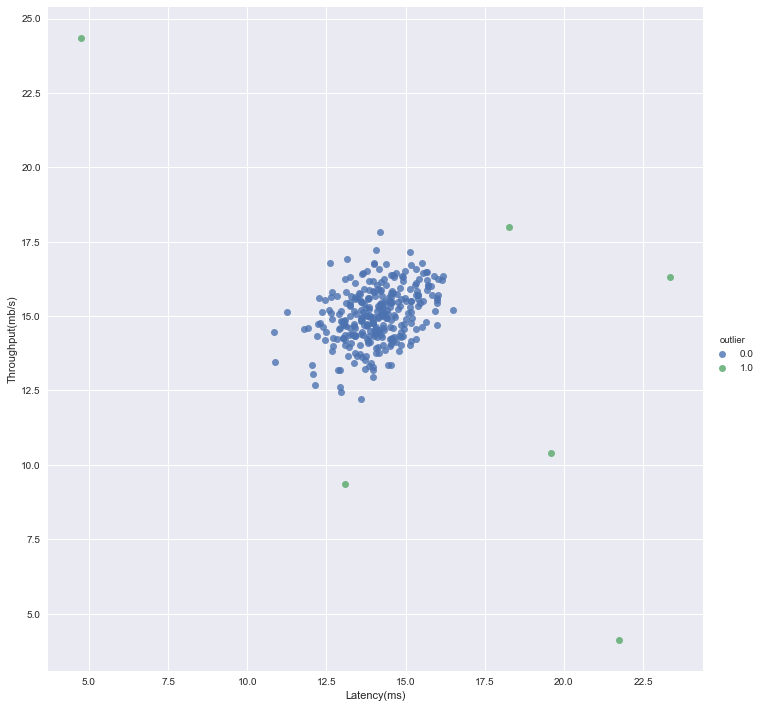

In [163]:
sns.lmplot(x = 'Latency(ms)', y = 'Throughput(mb/s)', size = (10), hue = 'outlier', data = train_df, fit_reg=False )